# Lista 3
## Jakub Ciągło (275986), Mateusz Ćwiek (276011)

___
## Importy

In [172]:
import numpy as np
import matplotlib.pyplot as plt8
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso,  LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
import seaborn as sns

___
## Zadanie 1
W zadaniu zaimplementowano **prostą regresję liniową** od podstaw przy użyciu metody **najmniejszych kwadratów (OLS)**. Celem było oszacowanie parametrów modelu liniowego ( $y = b_0 + b_1x + \varepsilon$ ), gdzie $b_0$ to wyraz wolny, $b_1$ to współczynnik kierunkowy, a $\varepsilon$ reprezentuje składnik losowy (szum).

W implementacji obliczono parametry estymatorów OLS według wzoru:
$$
\hat{b} = (X^T X)^{-1} X^T y
$$
czyli tak, by minimalizować sumę kwadratów reszt.



In [173]:
def ols(X, y):
    ones_column = np.ones((len(X), 1))
    Xmatrix = np.hstack((ones_column, X.reshape(-1, 1)))

    XtX = Xmatrix.T @ Xmatrix

    Xty = Xmatrix.T @ y

    b_hat = np.linalg.inv(XtX) @ Xty
    b_hat

    return b_hat

Dane zostały wygenerowane syntetycznie zgodnie z modelem ( $y = 3.5 + 2.0x + \text{szum}$ ), gdzie szum miał rozkład normalny o odchyleniu standardowym 2. Po dopasowaniu modelu otrzymano estymowane wartości parametrów bardzo zbliżone do prawdziwych.

Na wykresie przedstawiono punkty obserwacji oraz linię regresji uzyskaną metodą OLS. Linia dobrze oddaje trend danych, co potwierdza poprawność implementacji i dopasowania modelu.

Estymowany b0: 3.0740
Estymowany b1: 2.0622

Prawdziwy model użyty do generacji danych:
y = 3.5 + 2.0 * x + N(0, 4.0)


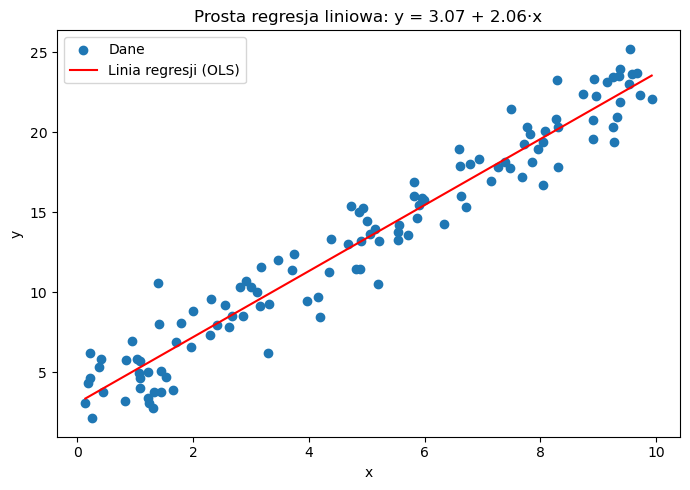

In [174]:
rng = np.random.default_rng(42)
n = 120
a_true = 3.5
b_true = 2.0
sigma = 2.0
noise = rng.normal(0, sigma, size=n)
x = rng.uniform(0, 10, size=n)
y = a_true + b_true * x + noise

b0_hat, b1_hat = ols(x, y)

y_hat = b0_hat + b1_hat * x

print(f"Estymowany b0: {b0_hat:.4f}")
print(f"Estymowany b1: {b1_hat:.4f}")
print()
print("Prawdziwy model użyty do generacji danych:")
print(f"y = {a_true} + {b_true} * x + N(0, {sigma**2})")


fig = plt.figure(figsize=(7, 5))
plt.scatter(x, y, label="Dane")
x_line = np.linspace(x.min(), x.max(), 200)
y_line = b0_hat + b1_hat * x_line
plt.plot(x_line, y_line, color="red", label="Linia regresji (OLS)")
plt.title(f"Prosta regresja liniowa: y = {b0_hat:.2f} + {b1_hat:.2f}·x")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

___
## Zadanie 2
W zadaniu wykorzystano klasę **LinearRegression** z biblioteki **scikit-learn**, aby rozwiązać ten sam problem regresji liniowej, co w poprzednim ćwiczeniu, i porównać wyniki z implementacją własną opartą na metodzie OLS.

Model został dopasowany do danych syntetycznych, a następnie porównano uzyskane współczynniki $b_0$ i $b_1$. Różnice między wynikami obu metod okazały się pomijalne, co potwierdza poprawność wcześniejszej implementacji oraz zgodność działania z teorią najmniejszych kwadratów.

,manual,sklearn,abs_diff
b0,3.074006,3.074006,3.730349e-14
b1,2.062192,2.062192,7.105427e-15


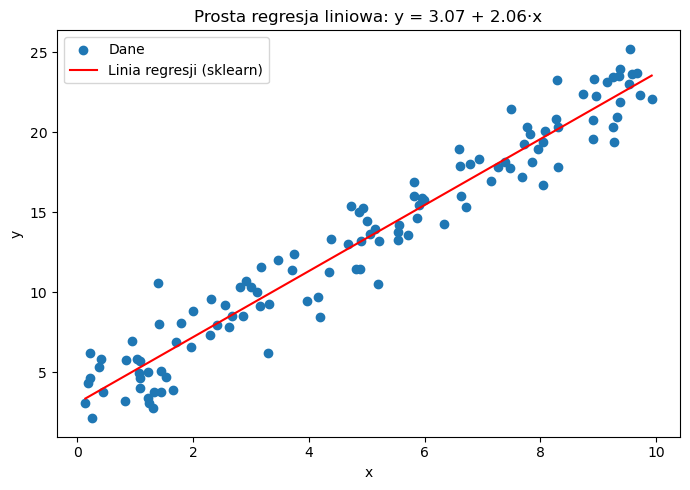

In [175]:
X_skl = x.reshape(-1, 1)
lr = LinearRegression()
lr.fit(X_skl, y)
y_hat_skl = lr.predict(X_skl)

coeffs_compare = pd.DataFrame({
    "manual": [b0_hat, b1_hat],
    "sklearn": [lr.intercept_, lr.coef_[0]],
    "abs_diff": [abs(b0_hat - lr.intercept_), abs(b1_hat - lr.coef_[0])]
}, index=["b0", "b1"])

display(coeffs_compare)

plt.figure(figsize=(7, 5))
plt.scatter(x, y, label="Dane")
x_line = np.linspace(x.min(), x.max(), 200)
plt.plot(x_line, lr.intercept_ + lr.coef_[0] * x_line, color="red", label="Linia regresji (sklearn)")
plt.title(f"Prosta regresja liniowa: y = {lr.intercept_:.2f} + {lr.coef_[0]:.2f}·x")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

W drugiej części zadania wykorzystano klasę **LinearRegression** z biblioteki *scikit-learn* do przeprowadzenia **regresji wielokrotnej** na rzeczywistym zbiorze danych *Boston Housing*. Celem było zbadanie zależności pomiędzy ceną domów (`MEDV`) a zestawem cech opisujących warunki mieszkaniowe (m.in. liczba pokoi, poziom zanieczyszczeń, odległość od centrów pracy).

Z danych usunięto obserwacje zawierające braki, po czym podzielono zbiór na część treningową i testową (80/20). Model został dopasowany do danych treningowych, a następnie dokonano predykcji na zbiorze testowym.

Do oceny jakości modelu wykorzystano funkcję `metrics`, obliczającą cztery miary błędu:

* **MSE** (średni błąd kwadratowy),
* **RMSE** (pierwiastek z MSE, łatwiejszy do interpretacji w jednostkach zmiennej zależnej),
* **MAE** (średni błąd bezwzględny),
* **R²** (współczynnik determinacji określający, jak dobrze model wyjaśnia zmienność danych).

Dodatkowo zestawiono współczynniki regresji dla poszczególnych cech i posortowano je według wartości bezwzględnych, co pozwala zidentyfikować zmienne o największym wpływie na cenę domu.

Na wykresie porównano wartości rzeczywiste i przewidziane `MEDV`. Punkty leżące blisko czerwonej linii ( $y = \hat{y}$ ) świadczą o dobrej jakości dopasowania.

In [176]:
def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return dict(MSE=mse, RMSE=rmse, MAE=mae, R2=r2)

In [177]:
df = pd.read_csv("Datasets/HousingData.csv")
df.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


,MSE,RMSE,MAE,R2
Test,31.454048,5.608391,3.367983,0.627085


,b_1,abs_b_1
NOX,-17.079257,17.079257
RM,4.258091,4.258091
CHAS,1.983837,1.983837
DIS,-1.424189,1.424189
PTRATIO,-0.975835,0.975835
LSTAT,-0.388620,0.388620
RAD,0.235588,0.235588
CRIM,-0.112187,0.112187
ZN,0.042440,0.042440
INDUS,0.025673,0.025673


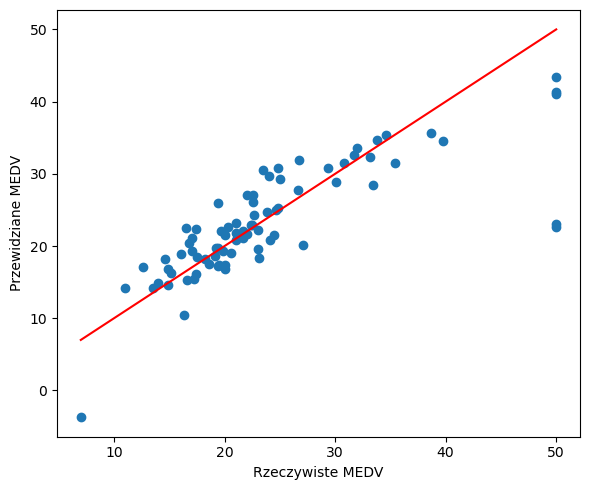

In [179]:
y_boston = df["MEDV"].values
X_boston = df.drop(columns=["MEDV"])

mask = pd.notnull(X_boston).all(axis=1) & pd.notnull(df["MEDV"])
X_boston = X_boston.loc[mask]
y_boston = y_boston[mask.values]

X_train, X_test, y_train, y_test = train_test_split(
    X_boston, y_boston, test_size=0.2, random_state=42
)

model_boston = LinearRegression()
model_boston.fit(X_train, y_train)
y_pred_test = model_boston.predict(X_test)

metrics_boston = metrics(y_test, y_pred_test)
metrics_boston_df = pd.DataFrame([metrics_boston], index=["Test"])

coefs = pd.Series(model_boston.coef_, index=X_boston.columns, name="coef")
coefs_sorted = coefs.reindex(coefs.abs().sort_values(ascending=False).index)
coefs_df = pd.DataFrame({"b_1": coefs_sorted, "abs_b_1": coefs_sorted.abs()})

display(metrics_boston_df)
display(coefs_df)

plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red")
plt.xlabel("Rzeczywiste MEDV")
plt.ylabel("Przewidziane MEDV")
plt.tight_layout()
plt.show()

___
## Zadanie 3
W zadaniu obliczono i porównano podstawowe **metryki oceny jakości modelu regresji** dla dwóch wersji: własnej implementacji OLS oraz modelu z biblioteki *scikit-learn*. Użyto czterech standardowych wskaźników:

* **MSE (Mean Squared Error)** — średni błąd kwadratowy, mierzy przeciętną kwadratową różnicę między wartościami rzeczywistymi a przewidywanymi; im mniejszy, tym lepsze dopasowanie,
* **RMSE (Root Mean Squared Error)** — pierwiastek z MSE, interpretowany w jednostkach zmiennej objaśnianej, co ułatwia ocenę błędu,
* **MAE (Mean Absolute Error)** — średni błąd bezwzględny, określa przeciętne odchylenie prognoz od wartości rzeczywistych,
* **R² (Coefficient of Determination)** — współczynnik determinacji, wskazuje, jaka część wariancji zmiennej objaśnianej jest wyjaśniana przez model; wartość bliska 1 oznacza dobre dopasowanie.


In [180]:
metrics_manual = metrics(y, y_hat)
metrics_skl = metrics(y, y_hat_skl)

metrics_compare = pd.DataFrame([metrics_manual, metrics_skl], index=["manual", "sklearn"])

display(metrics_compare)

,MSE,RMSE,MAE,R2
manual,2.408315,1.551875,1.273145,0.941648
sklearn,2.408315,1.551875,1.273145,0.941648



Porównanie wyników między modelem własnym a `LinearRegression` wykazało, że wszystkie metryki przyjmują niemal identyczne wartości, co potwierdza poprawność implementacji regresji liniowej wykonanej od podstaw.

____
## Zadanie 4

W tym zadaniu porównano klasyczną **regresję liniową** z jej dwoma regularyzowanymi odmianami — **Ridge** i **Lasso** — na danych obarczonych dodatkowym szumem.

Regularyzacja wprowadza **karę za duże wartości współczynników regresji**, co pomaga ograniczyć **nadmierne dopasowanie (overfitting)**.

* **Regresja liniowa** (`LinearRegression`) dopasowuje model minimalizując sumę błędów bez żadnych ograniczeń na wagi — przez co może być podatna na szum.
* **Ridge** dodaje karę w postaci sumy kwadratów współczynników (‖β‖²), dzięki czemu zmniejsza ich wartości, ale nie zeruje. W efekcie model jest stabilniejszy i mniej wrażliwy na szum.
* **Lasso** wprowadza karę L₁ (‖β‖₁), która może prowadzić do całkowitego wyzerowania niektórych wag, co czyni ją metodą selekcji cech.


,Model,b_0,b_1
0,Linear,13.307714,6.575994
1,Ridge,13.307714,6.521647
2,Lasso,13.307714,6.475994


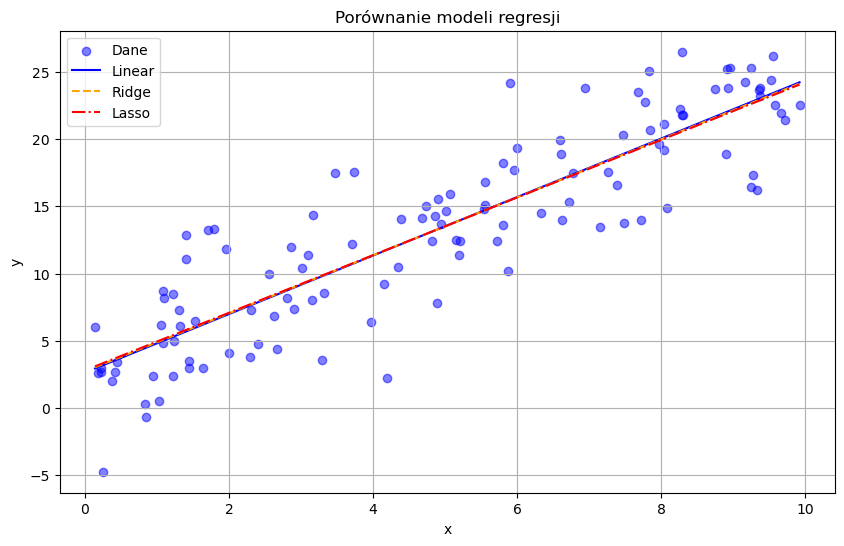

In [181]:
X = x.reshape(-1, 1)
sigma2 = 3
new_noise = rng.normal(0, sigma2, size=n)
y = y + new_noise
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lr = LinearRegression().fit(X_scaled, y)
ridge = Ridge(alpha=1.0).fit(X_scaled, y)
lasso = Lasso(alpha=0.1).fit(X_scaled, y)

coefs = pd.DataFrame({
    'Model': ['Linear', 'Ridge', 'Lasso'],
    'b_0': [lr.intercept_, ridge.intercept_, lasso.intercept_],
    'b_1': [lr.coef_[0], ridge.coef_[0], lasso.coef_[0]]
})

display(coefs)

x_sorted = np.sort(x)
X_sorted_scaled = scaler.transform(x_sorted.reshape(-1, 1))

y_pred_lr = lr.predict(X_sorted_scaled)
y_pred_ridge = ridge.predict(X_sorted_scaled)
y_pred_lasso = lasso.predict(X_sorted_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', alpha=0.5, label='Dane')
plt.plot(x_sorted, y_pred_lr, label='Linear', color='blue')
plt.plot(x_sorted, y_pred_ridge, label='Ridge', color='orange', linestyle = '--')
plt.plot(x_sorted, y_pred_lasso, label='Lasso', color='red', linestyle = '-.')
plt.title('Porównanie modeli regresji')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

___
## Zadanie 5

Zaimplementowano funkcję **sigmoidalną**, definiowaną jako
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$


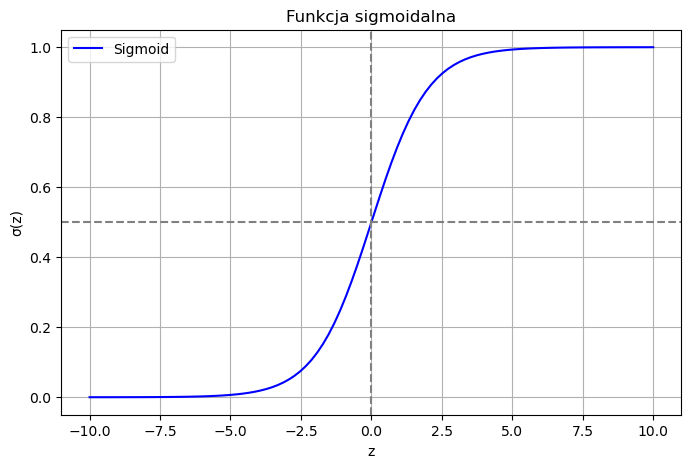

In [182]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-10, 10, 100)
s = sigmoid(z)

plt.figure(figsize=(8, 5))
plt.plot(z, s, label='Sigmoid', color='blue')
plt.axvline(0, color='gray', linestyle='--')
plt.axhline(0.5, color='gray', linestyle='--')
plt.title('Funkcja sigmoidalna')
plt.xlabel('z')
plt.ylabel('σ(z)')
plt.grid(True)
plt.legend()
plt.show()



Funkcja sigmoidalna przekształca wyjście modelu na wartość z przedziału (0, 1), umożliwiając interpretację jako prawdopodobieństwo.

Używana jest w regresji logistycznej, która jest podstawową techniką w klasyfikacji binarnej.

Jej kształt zapewnia gładkie przejście od klasy 0 do 1, co ułatwia optymalizację.

___ 
## Zadanie 6 
Wczytano zbiór **Breast Cancer Wisconsin** i przygotowano dane do klasyfikacji binarnej (zdrowy vs. złośliwy guz). Dane zostały podzielone na część treningową i testową oraz wystandaryzowane, co jest istotne dla poprawnego działania regresji logistycznej.

Następnie wytrenowano model **LogisticRegression** z biblioteki *scikit-learn* i wykonano predykcję na zbiorze testowym. Model uczy się, dopasowując parametry funkcji logistycznej tak, aby maksymalizować prawdopodobieństwo poprawnej klasyfikacji.

In [183]:
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

___
## Zadanie 7
Obliczono cztery kluczowe metryki oceny klasyfikacji. **Dokładność (accuracy)** pokazuje ogólny odsetek poprawnych przewidywań. **Precyzja (precision)** mierzy, jaki procent próbek oznaczonych jako pozytywne faktycznie nimi jest, natomiast **czułość (recall)** wskazuje, jak skutecznie model wykrywa przypadki pozytywne.

**Macierz pomyłek** wizualizuje liczbę poprawnych i błędnych klasyfikacji w podziale na klasy — dzięki niej można łatwo zauważyć, czy model częściej myli nowotwory złośliwe z łagodnymi, czy odwrotnie.

Dokładność (accuracy): 0.9737
Precyzja (precision): 0.9722
Czułość (recall): 0.9859


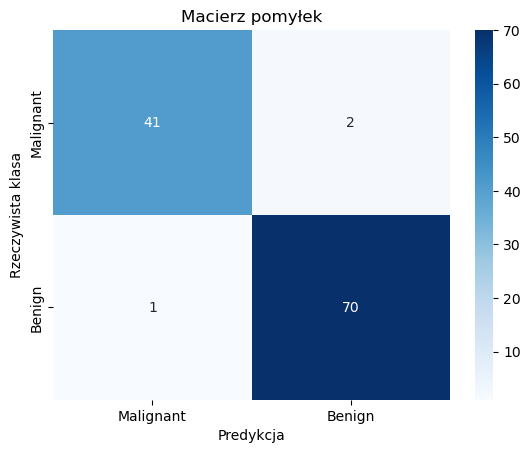

In [184]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność (accuracy): {accuracy:.4f}")

precision = precision_score(y_test, y_pred)
print(f"Precyzja (precision): {precision:.4f}")

recall = recall_score(y_test, y_pred)
print(f"Czułość (recall): {recall:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Malignant', 'Benign'], yticklabels=['Malignant', 'Benign'])
plt.xlabel("Predykcja")
plt.ylabel("Rzeczywista klasa")
plt.title("Macierz pomyłek")
plt.show()